In [27]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
import torchutils as tu
import torch.nn as nn
import numpy as np
DEVICE = 'cuda'
import time
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [28]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    
    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].set_ylim((0, max(history['train_losses'] + history['valid_losses']) + .1))
    ax[0].legend()
    
    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].set_ylim((0, 1))
    ax[1].legend()
    
    plt.show()

In [16]:
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

In [17]:
trnsfrms = T.Compose([T.RandomRotation(30),T.Resize((255, 255)),T.ToTensor()])
trnsfrms1 = T.Compose([T.Resize((255, 255)),T.ToTensor()])

train_dataset = datasets.ImageFolder(root='coffee-beans/train', transform=trnsfrms)
valid_dataset = datasets.ImageFolder(root='coffee-beans/test', transform=trnsfrms1)

train_loader = DataLoader(train_dataset, batch_size=36, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=36, shuffle=True)

model.fc = nn.Linear(512, 4)


In [29]:
def fit_model(
        model: nn.Module,
        epochs: int,
        optimizer: torch.optim.Optimizer,
        criterion: torch.nn.modules.loss,
        history=None
    ):
    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }
    
    f1 = []
    for epoch in range(1, epochs + 1):
        model.train()
        batch_losses = []
        batch_accs = []

        for samples, labels in train_loader:
            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)

            y_pred = model(samples)
            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            batch_accs.append((y_pred.argmax(dim=1) == labels).float().mean().item())

        train_loss = np.mean(batch_losses)
        train_acc  = np.mean(batch_accs)
        history['train_losses'].append(train_loss)
        history['train_accs'].append(train_acc)

        model.eval()
        batch_losses = []
        batch_accs = []
        with torch.no_grad():
            for samples, labels in valid_loader:
                samples = samples.to(DEVICE)
                labels = labels.to(DEVICE)
                y_pred = model(samples)
                
                # pred = y_pred.detach().cpu().numpy()
                # labels1 = labels.detach().cpu().numpy()
                # f1.append(f1_score(labels1,pred, average=None))
                
                loss = criterion(y_pred, labels)
                batch_losses.append(loss.item())
                batch_accs.append((y_pred.argmax(dim=1) == labels).float().mean().item())
                

        valid_loss = np.mean(batch_losses)
        valid_acc  = np.mean(batch_accs)
        history['valid_losses'].append(valid_loss)
        history['valid_accs'].append(valid_acc)

        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}"
        )
    return history, f1

Epoch 1/10 | Train Loss: 0.8417, Train Acc: 0.8762 | Val Loss: 0.7645, Val Acc: 0.8750
Epoch 2/10 | Train Loss: 0.6634, Train Acc: 0.9690 | Val Loss: 0.6520, Val Acc: 0.9745
Epoch 3/10 | Train Loss: 0.6339, Train Acc: 0.9820 | Val Loss: 0.5972, Val Acc: 1.0000
Epoch 4/10 | Train Loss: 0.6235, Train Acc: 0.9943 | Val Loss: 0.6455, Val Acc: 0.9815
Epoch 5/10 | Train Loss: 0.6290, Train Acc: 0.9869 | Val Loss: 0.6008, Val Acc: 1.0000
Epoch 6/10 | Train Loss: 0.6514, Train Acc: 0.9690 | Val Loss: 0.7362, Val Acc: 0.9074
Epoch 7/10 | Train Loss: 0.6392, Train Acc: 0.9788 | Val Loss: 0.6250, Val Acc: 0.9977
Epoch 8/10 | Train Loss: 0.6279, Train Acc: 0.9837 | Val Loss: 2.1398, Val Acc: 0.4144
Epoch 9/10 | Train Loss: 0.6113, Train Acc: 0.9910 | Val Loss: 0.5961, Val Acc: 1.0000
Epoch 10/10 | Train Loss: 0.6044, Train Acc: 0.9935 | Val Loss: 0.6657, Val Acc: 0.9514


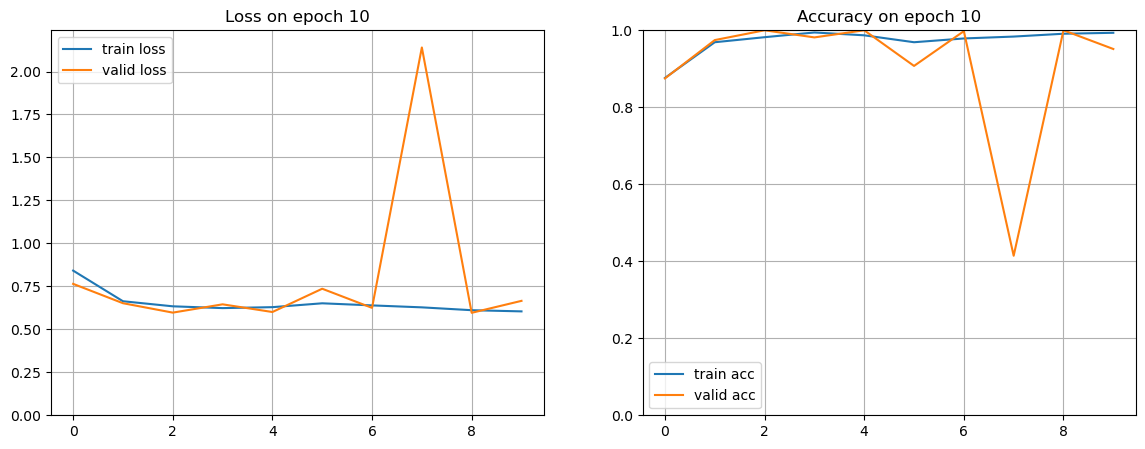

Время обучения модели составило 00:02:17


In [19]:
start_time = time.time()
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss(label_smoothing=.2)

model.to(DEVICE)
history, f1 = fit_model(model, optimizer=optimizer, criterion=criterion, epochs=10)

end_time = time.time()
training_time = end_time - start_time

plot_history(history)

convert = time.strftime("%H:%M:%S", time.gmtime(training_time))
print(f"Время обучения модели составило {convert}")

In [8]:
# model_scripted = torch.jit.script(model) # Export to TorchScript
# model_scripted.save('model1.pt')

In [30]:
model2 = torchvision.models.wide_resnet50_2(weights='IMAGENET1K_V2')

trnsfrms2 = T.Compose([T.Resize((255, 255)),T.ToTensor()])

train_dataset = datasets.ImageFolder(root='agricultural-images./train', transform=trnsfrms2)
valid_dataset = datasets.ImageFolder(root='agricultural-images./test', transform=trnsfrms2)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

model2.fc = nn.Linear(2048, 30)

for param in model2.parameters():
     param.requires_grad = False
    
model2.fc.weight.requires_grad = True
model2.fc.bias.requires_grad = True


Epoch 1/10 | Train Loss: 3.2286, Train Acc: 0.1525 | Val Loss: 3.0405, Val Acc: 0.3269
Epoch 2/10 | Train Loss: 2.5337, Train Acc: 0.4991 | Val Loss: 2.6183, Val Acc: 0.5449
Epoch 3/10 | Train Loss: 2.0269, Train Acc: 0.7675 | Val Loss: 2.2815, Val Acc: 0.6981
Epoch 4/10 | Train Loss: 1.6039, Train Acc: 0.8475 | Val Loss: 2.0217, Val Acc: 0.6862
Epoch 5/10 | Train Loss: 1.3670, Train Acc: 0.8267 | Val Loss: 1.8211, Val Acc: 0.7378
Epoch 6/10 | Train Loss: 1.1667, Train Acc: 0.9044 | Val Loss: 1.6909, Val Acc: 0.7378
Epoch 7/10 | Train Loss: 0.9217, Train Acc: 0.9285 | Val Loss: 1.5196, Val Acc: 0.7759
Epoch 8/10 | Train Loss: 0.9170, Train Acc: 0.9025 | Val Loss: 1.4617, Val Acc: 0.8019
Epoch 9/10 | Train Loss: 0.7384, Train Acc: 0.9152 | Val Loss: 1.3223, Val Acc: 0.8129
Epoch 10/10 | Train Loss: 0.6491, Train Acc: 0.9830 | Val Loss: 1.3026, Val Acc: 0.7945


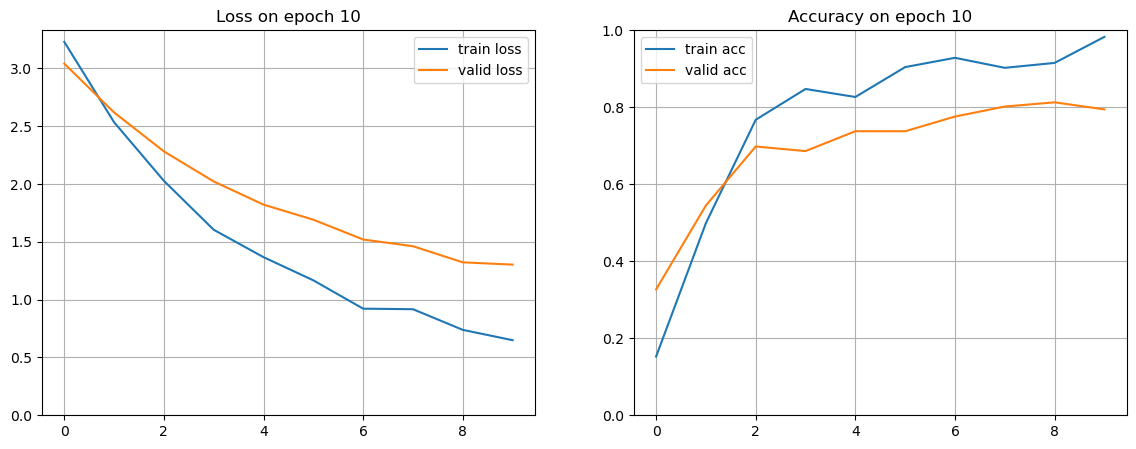

Время обучения модели составило 00:01:36


In [31]:
start_time = time.time()
optimizer = torch.optim.Adam(model2.parameters())
criterion = torch.nn.CrossEntropyLoss()

model2.to(DEVICE)
history, f1 = fit_model(model2, optimizer=optimizer, criterion=criterion, epochs=10)

end_time = time.time()
training_time = end_time - start_time

plot_history(history)

convert = time.strftime("%H:%M:%S", time.gmtime(training_time))
print(f"Время обучения модели составило {convert}")

In [32]:
# model_scripted = torch.jit.script(model2)
# model_scripted.save('model2.pt')